### Figure 1. Adaptible and cost-effective long-range multiplex PCR design in the context of a low complexity genome.

In [1]:
import os
import numpy as np
import pandas as pd
import pysam

from dataclasses import dataclass

from nomadic.lib.process_gffs import load_gff
from nomadic.lib.process_gffs import add_gff_fields
from nomadic.truthset.fasta import load_haplotype_from_fasta
from nomadic.lib.statistics import get_homopolymer_runs, calc_sliding_percentGC

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
plt.rcParams["figure.dpi"] = 100

## Functions

In [2]:
@dataclass
class AlignmentPlotData:
    read_id: str
    ref_start: int
    ref_end: int
    ref_name: str
    query_alignment_length: int
    mean_qscore: float
    forward: bool

    @classmethod
    def from_pysam_aligned_segment(cls, pysam_segment: pysam.AlignedSegment):
        """
        Extract alignment data for plotting from an aligned `pysam` segment

        """
        # Compute mean quality score
        qscores = np.array(pysam_segment.query_qualities)
        mean_qscore = qscores.mean() if qscores.shape else None

        return cls(
            read_id=pysam_segment.query_name,
            ref_start=pysam_segment.reference_start,
            ref_end=pysam_segment.reference_end,
            ref_name=pysam_segment.reference_name,
            query_alignment_length=pysam_segment.query_alignment_length,
            mean_qscore=mean_qscore,
            forward=pysam_segment.is_forward,
        )

In [3]:
def load_bam_info(bam_path):
    with pysam.AlignmentFile(bam_path, "r") as bam:
        bam_df = pd.DataFrame(
            [
                AlignmentPlotData.from_pysam_aligned_segment(alignment)
                for alignment in bam
            ]
        )
    return bam_df

## Settings

In [4]:
output_dir = "figures/fig1_visualise-reads"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

*General files*

In [5]:
gff_path = "../resources/plasmodb/52/PlasmoDB-52_Pfalciparum3D7.gff"
fasta_path = "../resources/plasmodb/52/PlasmoDB-52_Pfalciparum3D7_Genome.fasta"

*Multiplexes*

In [6]:
focus_barcode = 1

# 8PLEX
expt_dir8 = "../experiments/2021-11-14_strain-validation-flongle-lfb"
bam_dir_n8 = f"{expt_dir8}/nomadic/guppy/hac/single_end/barcodes/barcode{focus_barcode:02d}/target-extraction"

# 16PLEX
# BAM information
expt_dir16 = "../experiments/2021-11-20_strain-validation-16plex/"
bam_dir = f"{expt_dir16}/nomadic/guppy/hac/single_end/barcodes/barcode{focus_barcode:02d}/target-extraction"

# Multiplex information
mplx_primers = "../resources/multiply/multiplexes/multiplex.03.16plex.good.greedy.csv"
mplx_amp = "../resources/truthsets/stratifications/multiplex.03.16plex.good.greedy.full_amplicons.bed"
mplx_cds = "../resources/truthsets/stratifications/multiplex.03.16plex.good.greedy.cds.bed"


## Load data

*General files*

In [7]:
# Load GFF file
gff = load_gff(gff_path)
gff.rename({"seqid": "seqname"}, axis=1, inplace=True)

*Primer information*
- Only load 16plex, as 8plex is a subset of

In [8]:
primer_df = pd.read_csv(mplx_primers)

In [9]:
name_to_id = dict(zip(primer_df["gene_name"], primer_df["target"]))
name_to_id = {
    k if k != "MDR1part" else "MDR1" : v
    for k, v in name_to_id.items()
}
target_names = list(name_to_id.keys())
id_to_name = {v: k for k, v in name_to_id.items()}

In [16]:
target_names_n8 = [
    "CRT1",
    "DHFR",
    "DHPS",
    "K13",
    "MDR1",
    "MSP2",
    "PMI",
    "PMIII"
]

*Amplicon sizes*

In [10]:
# AMPLICON N16
# Load
mplx_amp_df = pd.read_csv(mplx_amp,
                             sep="\t",
                             names=["chrom", "start", "end", "target_id"])

# Annotate
mplx_amp_df.insert(
    3,
    "length",
    mplx_amp_df["end"] - mplx_amp_df["start"]
)
mplx_amp_df.insert(5, "target_name", [id_to_name[i] for i in mplx_amp_df["target_id"]])
mplx_amp_df["target_name"] = [
    t if t != "MDR1part" else "MDR1"
    for t in mplx_amp_df["target_name"]
]

# Sort
mplx_amp_df.sort_values("target_name", ascending=True, inplace=True)

*Coding sequences*

In [11]:
# CODING SEQUENCE FOR N16
# Load
mplx_cds_df = pd.read_csv(mplx_cds,
                             sep="\t",
                             names=["chrom", "start", "end", "exon_name"])

# Annotate
mplx_cds_df.insert(
    0,
    "target_id",
    [e.split(".")[0] for e in mplx_cds_df["exon_name"]]
)
mplx_cds_df.insert(
    3,
    "length",
    mplx_cds_df["end"] - mplx_cds_df["start"]
)

# Create summary
mplx_cds_df = (mplx_cds_df
                  .groupby("target_id")
                  .agg(
                      cds_start=pd.NamedAgg("start", min),
                      cds_end=pd.NamedAgg("end", max)
                  )
                  .reset_index()
                 )
mplx_cds_df.insert(
    3,
    "length",
    mplx_cds_df["cds_end"] - mplx_cds_df["cds_start"]
)
mplx_cds_df.insert(
    1,
    "target_name",
    [id_to_name[i] for i in mplx_cds_df["target_id"]]
)

*Sequence complexity information*

In [12]:
seq_comp = {
    "target_name": [],
    "per_at": [],
    "hp_runs": []
}
print("Loading sequence complexity information...")
for target_name in target_names:
    # Extract region
    #target_id = name_to_id[target_name]
    r = mplx_amp_df.query("target_name == @target_name").squeeze()
    region = f"{r['chrom']}:{r['start']}-{r['end']}"
    
    # Load sequence
    seq = load_haplotype_from_fasta(fasta_path, region=region)
    print(f"  Loaded sequence of {len(seq)}bp for {target_name}...")
    
    # Compute summary statistics
    hp_runs = get_homopolymer_runs(seq)
    per_at = 1 - calc_sliding_percentGC(seq, window=20)
    N_bp = hp_runs.shape[0]
    
    # Store
    seq_comp["target_name"].extend([target_name]*N_bp)
    seq_comp["per_at"].extend(per_at.tolist())
    seq_comp["hp_runs"].extend(hp_runs.tolist())
seq_comp_df = pd.DataFrame(seq_comp)
seq_comp_df.sort_values("target_name", ascending=True, inplace=True)
print("Done.")

Loading sequence complexity information...
  Loaded sequence of 3774bp for MDR1...
  Loaded sequence of 3721bp for MSP2...
  Loaded sequence of 3464bp for DHFR...
  Loaded sequence of 3875bp for CRT1...
  Loaded sequence of 3657bp for DHPS...
  Loaded sequence of 3827bp for K13...
  Loaded sequence of 3102bp for PMI...
  Loaded sequence of 3469bp for PMIII...
  Loaded sequence of 3108bp for CSP...
  Loaded sequence of 3367bp for HRP2up...
  Loaded sequence of 3098bp for HRP2...
  Loaded sequence of 3334bp for HRP2dwn...
  Loaded sequence of 3139bp for AMA1...
  Loaded sequence of 3067bp for HRP3up...
  Loaded sequence of 3445bp for HRP3...
  Loaded sequence of 3304bp for HRP3dwn...
Done.


In [13]:
# Create a homopolymer summary data frame
hp_df = \
(seq_comp_df
 .groupby("target_name")
 .agg(
     n = pd.NamedAgg("hp_runs", len),
     hp_3 = pd.NamedAgg("hp_runs", lambda x: sum(x >= 3)/len(x)),
     hp_4 = pd.NamedAgg("hp_runs", lambda x: sum(x >= 4)/len(x)),
     hp_5 = pd.NamedAgg("hp_runs", lambda x: sum(x >= 5)/len(x)),
     hp_6 = pd.NamedAgg("hp_runs", lambda x: sum(x >= 6)/len(x)), 
     hp_9 = pd.NamedAgg("hp_runs", lambda x: sum(x >= 9)/len(x)), 
 )
 .reset_index()
)
hp_df.sort_values("target_name", ascending=True, inplace=True)

### Load read lengths from BAM

*8plex*

In [19]:
bam_dfs = []
target_overlaps_n8 = {}
for target_name in target_names_n8:
    # Load BAM file
    bam_path = f"{bam_dir_n8}/reads.target.{target_name}.bam"
    bam_df = load_bam_info(bam_path)
    
    # Annotate
    bam_df.insert(0, "target_name", target_name)
    
    # Store
    print(f"  Loaded {bam_df.shape[0]} reads for {target_name}...")
    bam_dfs.append(bam_df)
    
    # Compute number of reads overlapping ORF
    target_info = mplx_cds_df.query("target_name == @target_name").squeeze()
    left_outside = bam_df["ref_start"] <= target_info["cds_start"]
    right_outside = bam_df["ref_end"] >= target_info["cds_end"]
    outside = left_outside & right_outside
    per_overlap = 100 * outside.sum() / outside.shape[0]
    target_overlaps_n8[target_name] = per_overlap
    
bam_n8_df = pd.concat(bam_dfs)
bam_n8_df.sort_values("target_name", ascending=True, inplace=True)
print("Done.")

  Loaded 246 reads for CRT1...
  Loaded 1565 reads for DHFR...
  Loaded 1507 reads for DHPS...
  Loaded 1941 reads for K13...
  Loaded 1984 reads for MDR1...
  Loaded 635 reads for MSP2...
  Loaded 828 reads for PMI...
  Loaded 636 reads for PMIII...
Done.


*16plex*

In [20]:
bam_dfs = []
target_overlaps = {}
for target_name in name_to_id:
    # Load BAM file
    bam_path = f"{bam_dir}/reads.target.{target_name}.bam"
    bam_df = load_bam_info(bam_path)
    
    # Annotate
    bam_df.insert(0, "target_name", target_name)
    
    # Store
    print(f"  Loaded {bam_df.shape[0]} reads for {target_name}...")
    bam_dfs.append(bam_df)
    
    # Compute number of reads overlapping ORF
    target_info = mplx_cds_df.query("target_name == @target_name").squeeze()
    left_outside = bam_df["ref_start"] <= target_info["cds_start"]
    right_outside = bam_df["ref_end"] >= target_info["cds_end"]
    outside = left_outside & right_outside
    per_overlap = 100 * outside.sum() / outside.shape[0]
    target_overlaps[target_name] = per_overlap
    
bam_n16_df = pd.concat(bam_dfs)
bam_n16_df.sort_values("target_name", ascending=True, inplace=True)
print("Done.")

[E::idx_find_and_load] Could not retrieve index file for '../experiments/2021-11-20_strain-validation-16plex//nomadic/guppy/hac/single_end/barcodes/barcode01/target-extraction/reads.target.MDR1.bam'
[E::idx_find_and_load] Could not retrieve index file for '../experiments/2021-11-20_strain-validation-16plex//nomadic/guppy/hac/single_end/barcodes/barcode01/target-extraction/reads.target.MSP2.bam'


  Loaded 3543 reads for MDR1...
  Loaded 2316 reads for MSP2...


[E::idx_find_and_load] Could not retrieve index file for '../experiments/2021-11-20_strain-validation-16plex//nomadic/guppy/hac/single_end/barcodes/barcode01/target-extraction/reads.target.DHFR.bam'


  Loaded 5115 reads for DHFR...
  Loaded 239 reads for CRT1...
  Loaded 1710 reads for DHPS...


[E::idx_find_and_load] Could not retrieve index file for '../experiments/2021-11-20_strain-validation-16plex//nomadic/guppy/hac/single_end/barcodes/barcode01/target-extraction/reads.target.CRT1.bam'
[E::idx_find_and_load] Could not retrieve index file for '../experiments/2021-11-20_strain-validation-16plex//nomadic/guppy/hac/single_end/barcodes/barcode01/target-extraction/reads.target.DHPS.bam'
[E::idx_find_and_load] Could not retrieve index file for '../experiments/2021-11-20_strain-validation-16plex//nomadic/guppy/hac/single_end/barcodes/barcode01/target-extraction/reads.target.K13.bam'


  Loaded 2951 reads for K13...
  Loaded 241 reads for PMI...
  Loaded 1976 reads for PMIII...


[E::idx_find_and_load] Could not retrieve index file for '../experiments/2021-11-20_strain-validation-16plex//nomadic/guppy/hac/single_end/barcodes/barcode01/target-extraction/reads.target.PMI.bam'
[E::idx_find_and_load] Could not retrieve index file for '../experiments/2021-11-20_strain-validation-16plex//nomadic/guppy/hac/single_end/barcodes/barcode01/target-extraction/reads.target.PMIII.bam'
[E::idx_find_and_load] Could not retrieve index file for '../experiments/2021-11-20_strain-validation-16plex//nomadic/guppy/hac/single_end/barcodes/barcode01/target-extraction/reads.target.CSP.bam'


  Loaded 1667 reads for CSP...
  Loaded 1118 reads for HRP2up...
  Loaded 313 reads for HRP2...


[E::idx_find_and_load] Could not retrieve index file for '../experiments/2021-11-20_strain-validation-16plex//nomadic/guppy/hac/single_end/barcodes/barcode01/target-extraction/reads.target.HRP2up.bam'
[E::idx_find_and_load] Could not retrieve index file for '../experiments/2021-11-20_strain-validation-16plex//nomadic/guppy/hac/single_end/barcodes/barcode01/target-extraction/reads.target.HRP2.bam'
[E::idx_find_and_load] Could not retrieve index file for '../experiments/2021-11-20_strain-validation-16plex//nomadic/guppy/hac/single_end/barcodes/barcode01/target-extraction/reads.target.HRP2dwn.bam'


  Loaded 2239 reads for HRP2dwn...
  Loaded 1140 reads for AMA1...
  Loaded 51 reads for HRP3up...
  Loaded 569 reads for HRP3...
  Loaded 211 reads for HRP3dwn...
Done.


[E::idx_find_and_load] Could not retrieve index file for '../experiments/2021-11-20_strain-validation-16plex//nomadic/guppy/hac/single_end/barcodes/barcode01/target-extraction/reads.target.AMA1.bam'
[E::idx_find_and_load] Could not retrieve index file for '../experiments/2021-11-20_strain-validation-16plex//nomadic/guppy/hac/single_end/barcodes/barcode01/target-extraction/reads.target.HRP3up.bam'
[E::idx_find_and_load] Could not retrieve index file for '../experiments/2021-11-20_strain-validation-16plex//nomadic/guppy/hac/single_end/barcodes/barcode01/target-extraction/reads.target.HRP3.bam'
[E::idx_find_and_load] Could not retrieve index file for '../experiments/2021-11-20_strain-validation-16plex//nomadic/guppy/hac/single_end/barcodes/barcode01/target-extraction/reads.target.HRP3dwn.bam'


## Plot

*Ordering*

In [28]:
NOMADS8_ORDER = [
    "CRT1",
    "DHFR",
    "DHPS",
    "K13",
    "MDR1",
    "MSP2",
    "PMI",
    "PMIII"
]
NOMADS16_ORDER = NOMADS8_ORDER + [
    "AMA1",
    "CSP",
    "HRP2up",
    "HRP2",
    "HRP2dwn",
    "HRP3up",
    "HRP3",
    "HRP3dwn"
]

In [29]:
mplx_amp_df["target_name"] = pd.Categorical(
    values=mplx_amp_df["target_name"],
    categories=NOMADS16_ORDER,
    ordered=True
)

In [87]:
mplx_cds_df["target_name"] = pd.Categorical(
    values=mplx_cds_df["target_name"],
    categories=NOMADS16_ORDER,
    ordered=True
)

In [88]:
mplx_cds_n8_df = mplx_cds_df.query("target_name in @NOMADS8_ORDER")
mplx_cds_n8_df["target_name"] = pd.Categorical(
    values=mplx_cds_n8_df["target_name"],
    categories=NOMADS8_ORDER,
    ordered=True
)

/Users/jasongms/opt/anaconda3/envs/nomadic2/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [89]:
bam_n8_df["target_name"] = pd.Categorical(
    values=bam_n8_df["target_name"],
    categories=NOMADS8_ORDER,
    ordered=True
)
bam_n8_df.sort_values("target_name", inplace=True)

In [90]:
bam_n16_df["target_name"] = pd.Categorical(
    values=bam_n16_df["target_name"],
    categories=NOMADS16_ORDER,
    ordered=True
)
bam_n16_df.sort_values("target_name", inplace=True)

In [91]:
hp_df["target_name"] = pd.Categorical(
    values=hp_df["target_name"],
    categories=NOMADS16_ORDER,
    ordered=True
)
hp_df.sort_values("target_name", inplace=True)

In [92]:
seq_comp_df["target_name"] = pd.Categorical(
    values=seq_comp_df["target_name"],
    categories=NOMADS16_ORDER,
    ordered=True
)
seq_comp_df.sort_values("target_name", inplace=True)

*Colors*
- I would want this to stay consistent across the manuscript

In [93]:
COLS = sns.color_palette("viridis", 8) + sns.color_palette("inferno", 8)

*Main plot*

/Users/jasongms/opt/anaconda3/envs/nomadic2/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
/Users/jasongms/opt/anaconda3/envs/nomadic2/lib/python3.7/site-packages/ipykernel_launcher.py:112: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


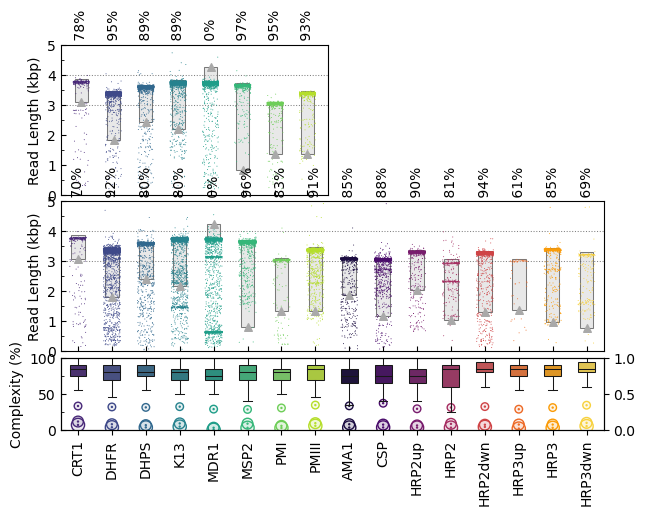

In [110]:
# Size figure
width = 7
height = 5
fig = plt.figure(figsize=(width, height))
fig.subplots_adjust(hspace=0.5)


# Prepare grid
gs = GridSpec(nrows=20, ncols=10)

ax_rl_8 = plt.subplot(gs[0:8, :5])
ax_rl_16 = plt.subplot(gs[8:16, :])
ax_at = plt.subplot(gs[16:20, :], sharex=ax_rl_16)
#ax_hp = plt.subplot(gs[16:20, :], sharex=ax_rl)


# ----------------------------------------
# READ LENGHTS
# ----------------------------------------
RL_YLIMS = np.array([0, 5000])
add_lines = True
add_amplicons = True
add_per_annotations = True
RESCALE=10**3

# 8PLEX
ax = ax_rl_8
# Plot
sns.stripplot(
    x=bam_n8_df["target_name"],
    y=bam_n8_df["query_alignment_length"]/RESCALE,
    palette=COLS[:8],
    jitter=0.25,
    s=0.7,
    ax=ax
)

# Limits
ax.set_ylim(RL_YLIMS/RESCALE)

# Lines
if add_lines:
    ax.set_axisbelow(True)
    line_args = {"zorder": -10, 
                 "color": "grey", 
                 "lw": 0.75,
                 "linestyle": "dotted"}
    ax.axhline(y=3000/RESCALE, **line_args)
    ax.axhline(y=4000/RESCALE, **line_args)

# Ticks
ax.tick_params(
    which='both',
    direction='in',
    labelbottom=False
)
ax.yaxis.set_minor_locator(plt.MultipleLocator(500/RESCALE))

# Labels
ax.set_ylabel("Read Length (kbp)")

# Amplicons
if add_amplicons:
    box_wd = 0.2
    for ix, target_name in enumerate(NOMADS8_ORDER):
        amp_length = mplx_amp_df.query("target_name == @target_name").squeeze()["length"]
        cds_length = mplx_cds_df.query("target_name == @target_name").squeeze()["length"]
        height = amp_length - cds_length
        rectangle = Rectangle(
            xy=(ix-0.2, cds_length/RESCALE),
            width=0.2*2,
            height=height/RESCALE,
            ec="black",
            fc="lightgrey",
            alpha=0.5,
            lw=0.75
        )
        ax.add_artist(rectangle)
        
    # CDS
    ax.scatter(
        x=mplx_cds_n8_df["target_name"],
        y=mplx_cds_n8_df["length"]/RESCALE,
        marker="^",
        color="darkgrey",
        s=30,
        zorder=10,
        label="ORF"
    )
    
# Annotate
if add_per_annotations:
    for ix, target_name in enumerate(NOMADS8_ORDER):
        per = target_overlaps_n8[target_name]
        ax.annotate(
            xy=(ix, ax.get_ylim()[1]),
            ha="center", va="bottom",
            rotation=90,
            text=f" {per:.0f}%"
        )


# 16PLEX
ax = ax_rl_16
# Plot
sns.stripplot(
    x=bam_n16_df["target_name"],
    y=bam_n16_df["query_alignment_length"]/RESCALE,
    palette=COLS,
    jitter=0.25,
    s=0.7,
    ax=ax
)

# Limits
ax.set_ylim(RL_YLIMS/RESCALE)

# Lines
if add_lines:
    ax.set_axisbelow(True) 
    ax.axhline(y=3000/RESCALE, **line_args)
    ax.axhline(y=4000/RESCALE, **line_args)

# Ticks
ax.tick_params(
    which='both',
    direction='in',
    labelbottom=False
)
ax.yaxis.set_minor_locator(plt.MultipleLocator(500/RESCALE))

# Labels
ax.set_ylabel("Read Length (kbp)")

# Amplicons
if add_amplicons:
    box_wd = 0.2
    for ix, target_name in enumerate(NOMADS16_ORDER):
        amp_length = mplx_amp_df.query("target_name == @target_name").squeeze()["length"]
        cds_length = mplx_cds_df.query("target_name == @target_name").squeeze()["length"]
        height = amp_length - cds_length
        rectangle = Rectangle(
            xy=(ix-0.2, cds_length/RESCALE),
            width=0.2*2,
            height=height/RESCALE,
            ec="black",
            fc="lightgrey",
            alpha=0.5,
            lw=0.75
        )
        ax.add_artist(rectangle)
        
    # CDS
    ax.scatter(
        x=mplx_cds_df["target_name"],
        y=mplx_cds_df["length"]/RESCALE,
        marker="^",
        color="darkgrey",
        s=30,
        zorder=10,
        label="ORF"
    )

# Annotate
if add_per_annotations:
    for ix, target_name in enumerate(NOMADS16_ORDER):
        per = target_overlaps[target_name]
        ax.annotate(
            xy=(ix, ax.get_ylim()[1]),
            ha="center", va="bottom",
            rotation=90,
            text=f" {per:.0f}%"
        )
    
    

# ----------------------------------------
# Sequence Complexity
# ----------------------------------------
# AT PERCENTAGE
ax = ax_at
# Plot
sns.boxplot(
    x=seq_comp_df["target_name"],
    y=seq_comp_df["per_at"]*100,
    palette=COLS,
    width=0.5,
    showfliers=False,
    linewidth=0.75,
    ax=ax,
)

# Limit
ax.set_ylim((0, 100))
ax.set_ylabel("Complexity (%)")


# HOMOPOLYMERS
ax_hp = ax.twinx()
# Plot
szs = [3, 6, 9]
for sz in szs:
    ax.scatter(
        x=hp_df["target_name"],
        y=hp_df[f"hp_{sz}"]*100,
        s=sz*10,
        fc=[c + (0.1,) for c in COLS],
        ec=COLS,
        lw=1,
        label=f">{sz}bp"
    )
    ax.scatter(
        x=hp_df["target_name"],
        y=hp_df[f"hp_{sz}"]*100,
        marker=".",
        s=2,
        c=COLS,
        lw=1
    )
    
# Limits
ax.set_ylim((0, 100))

# Labels
ax.set_xlabel("")


# Ticks
ax.yaxis.set_minor_locator(plt.MultipleLocator(25))
# y
ax.tick_params(
    which='both',
    axis='y',
    direction='in',
    labelright=False,
)
# x
ax.tick_params(
    axis='x',
    direction='out',
    labelbottom=True,
    rotation=90
)

    
    
# ----------------------------------------
# Save
# ----------------------------------------
fig.savefig(f"{output_dir}/summary_stats.n8.n16.box.pdf", 
            dpi=300, bbox_inches="tight",
            pad_inches=0.5)

TODO
- Remove x tick labels

In [ ]:
# Size figure
width = 6
height = 4
fig = plt.figure(figsize=(width, height))
fig.subplots_adjust(hspace=0.15)

# Prepare grid
gs = GridSpec(nrows=20, ncols=1)
ax_rl = plt.subplot(gs[0:12])
ax_at = plt.subplot(gs[12:16], sharex=ax_rl)
ax_hp = plt.subplot(gs[16:20], sharex=ax_rl)

# READ LENGTHS
ax = ax_rl
# Plot
sns.stripplot(
    x=bam_df["target_name"],
    y=bam_df["query_alignment_length"],
    palette=COLS,
    jitter=0.25,
    s=0.7,
    ax=ax
)
# Amplicons
box_wd = 0.2
for ix, target_name in enumerate(mplx_amp_df["target_name"]):
    amp_length = mplx_amp_df.query("target_name == @target_name").squeeze()["length"]
    cds_length = mplx_cds_df.query("target_name == @target_name").squeeze()["length"]
    height = amp_length - cds_length
    rectangle = Rectangle(
        xy=(ix-0.2, cds_length),
        width=0.2*2,
        height=height,
        ec="black",
        fc="lightgrey",
        alpha=0.5,
        lw=0.75
    )
    ax.add_artist(rectangle)
# CDS
ax.scatter(
    x=mplx_cds_df["target_name"],
    y=mplx_cds_df["length"],
    marker="o",
    color="darkgrey",
    s=20,
    zorder=3,
    label="ORF"
)
ax.set_xticklabels([])
    


# ax.scatter(
#     x=mplx_amp_df["target_name"],
#     y=mplx_amp_df["length"],
#     marker="v",
#     lw=1,
#     color="black",
#     s=20,
#     zorder=-3,
#     label="Amplicon"
# )
# # CDS
# ax.scatter(
#     x=mplx_cds_df["target_name"],
#     y=mplx_cds_df["length"],
#     marker="o",
#     color="black",
#     s=20,
#     zorder=-3,
#     label="ORF"
# )
# ax.legend(bbox_to_anchor=(1, 1), loc="upper left", title="Length (bp)")



# Limits
ax.set_ylim((0, 5000))

# Ticks
ax.yaxis.set_minor_locator(plt.MultipleLocator(500))

# Lines
ax.set_axisbelow(True) 
ax.axhline(y=3000, zorder=-10, color='grey', lw=0.75)
ax.axhline(y=4000, zorder=-10, color='grey', lw=0.75)
ax.grid(axis='y', ls='dotted', which='both')

# Label
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda val, ix: int(val) if val != 0 else None))
ax.set_ylabel("Read Length (bp)")

# Annotate
for ix, target_name in enumerate(mplx_amp_df["target_name"]):
    per = target_overlaps[target_name]
    ax.annotate(
        xy=(ix, ax.get_ylim()[1]),
        ha="center", va="bottom",
        rotation=90,
        text=f" {per:.0f}%"
    )


# AT PERCENTAGE
ax = ax_at
# Plot
sns.boxplot(
    x=seq_comp_df["target_name"],
    y=seq_comp_df["per_at"],
    palette=COLS,
    width=0.5,
    showfliers=False,
    linewidth=0.75,
    ax=ax
)
#ax.set_xticklabels([])

# Limit
ax.set_ylim((0, 1.0))

# Lines
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.set_axisbelow(True) 
ax.grid(ls='dotted', axis='y')

# Labels
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda val, ix: int(100*val) if val != 0 else None))
ax.set_ylabel("AT (%)")

# HP STATISTICS
ax = ax_hp
# Plot
szs = [3, 6, 9]
for sz in szs:
    ax.scatter(
        x=hp_df["target_name"],
        y=hp_df[f"hp_{sz}"],
        s=sz*10,
        fc=[c + (0.1,) for c in COLS],
        ec=COLS,
        lw=1,
        label=f">{sz}bp"
    )
    ax.scatter(
        x=hp_df["target_name"],
        y=hp_df[f"hp_{sz}"],
        marker=".",
        s=2,
        c=COLS,
        lw=1
    )

# Limit
ax.set_ylim((0, 0.4))
plt.tick_params(axis="x", rotation=90)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Lines
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.05))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.set_axisbelow(True) 
ax.grid(ls='dotted', axis='y')

# Label
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda val, ix: int(100*val)))
ax.set_ylabel("HP (%)")

# Legend
ax.legend(bbox_to_anchor=(1, 1), loc="upper left")

fig.savefig(f"{output_dir}/summary_stats.n16.box.pdf", 
            dpi=300, bbox_inches="tight",
            pad_inches=0.5)